

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Get Data


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp   
from PIL import Image

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[4])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[2]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':15},
        'lenet':{'dropout':0.1, 'epochs':15},
        'custom':{'dropout':0.1, 'epochs':15},
        'vgg':{'dropout':0.3, 'epochs':15},
        'resnet':{'epochs':15},
        'pretrained':{'epochs':15}   
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-12 14:58:01,318: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/results.json


In [5]:
params.use_data_augmentation

True

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*10<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [8]:
Counter(train_labels)

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

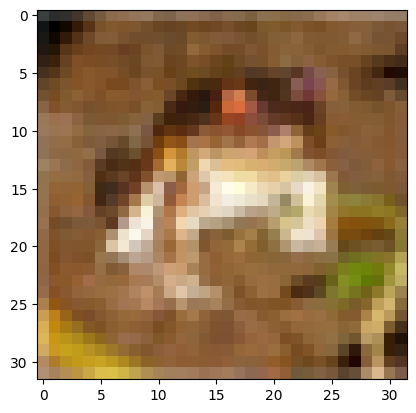

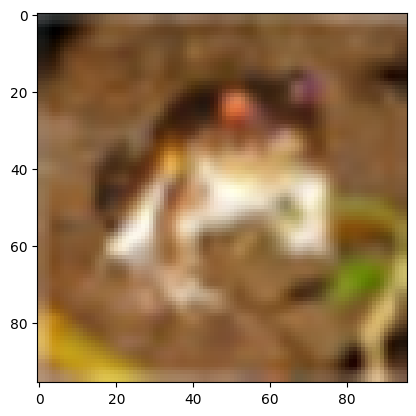

(32, 32, 3) (96, 96, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(96, 96) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [11]:
train_images = resize_images(train_images, input_shape)
test_images = resize_images(test_images, input_shape)

AttributeError: 'numpy.ndarray' object has no attribute 'input_shape'

In [13]:
print(train_images.shape, type(train_images), train_images.dtype)
print(test_images.shape, type(test_images), test_images.dtype) 

(50000, 96, 96, 3) <class 'numpy.ndarray'> uint8
(10000, 96, 96, 3) <class 'numpy.ndarray'> uint8




### Data Explore 

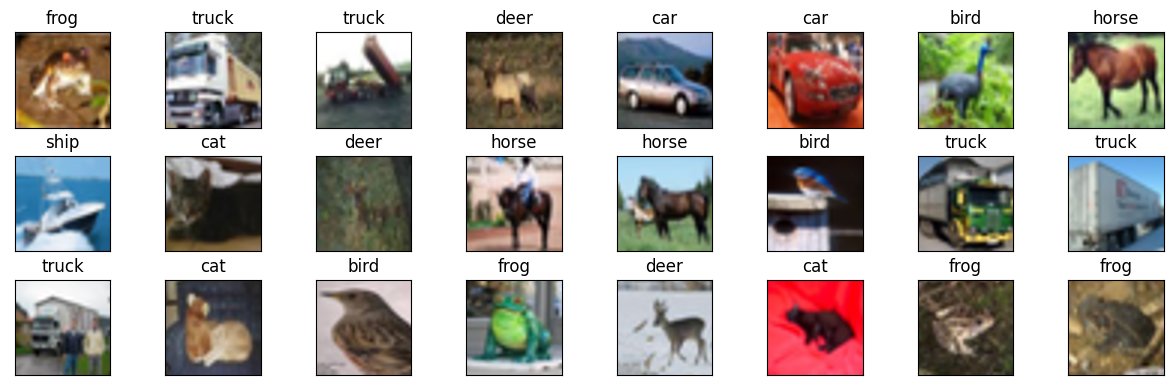

In [14]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Class Distribution

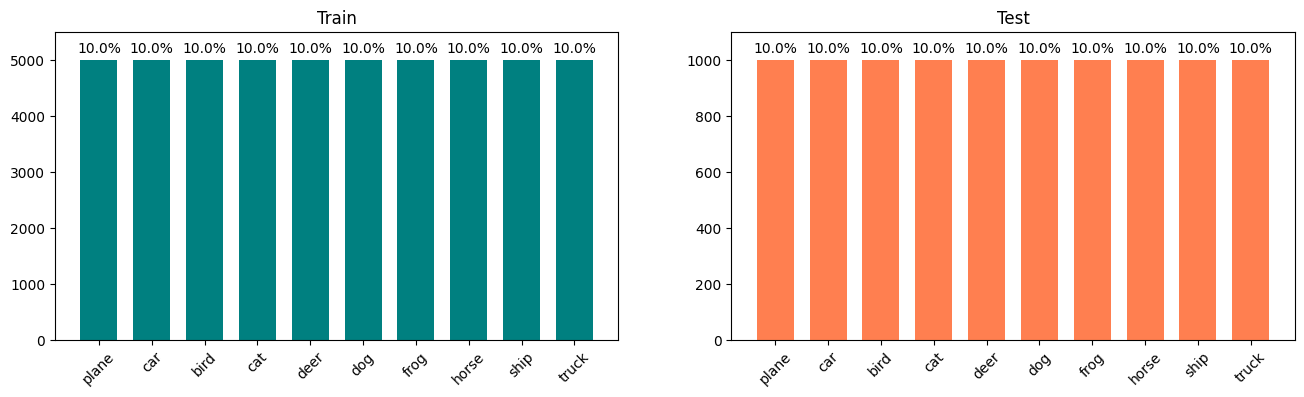

In [15]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [16]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [17]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [18]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

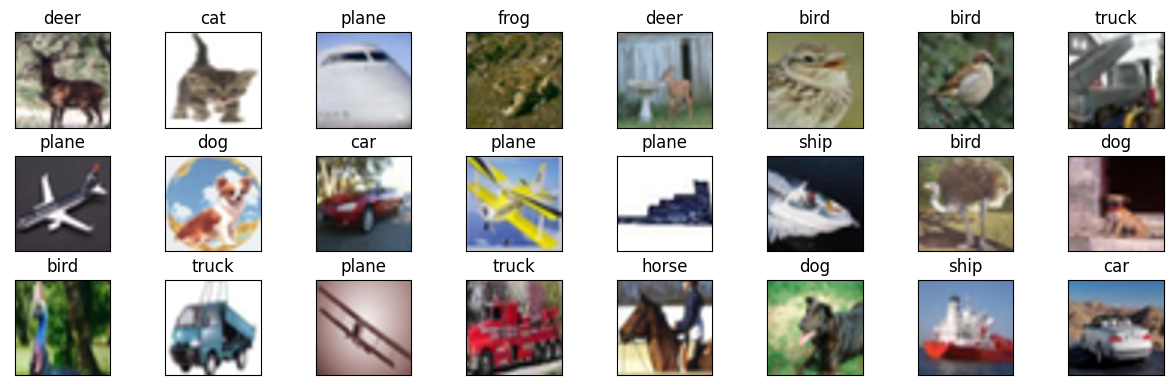

In [19]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [20]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

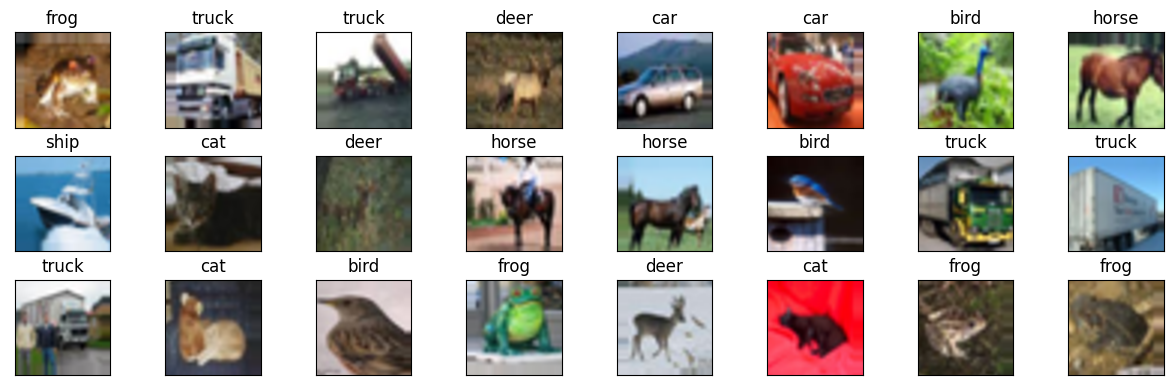

In [21]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

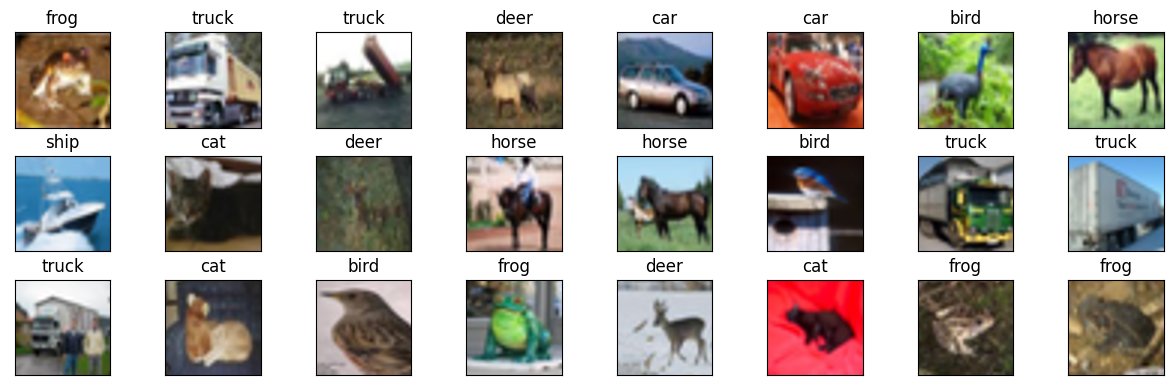

In [22]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [23]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [24]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


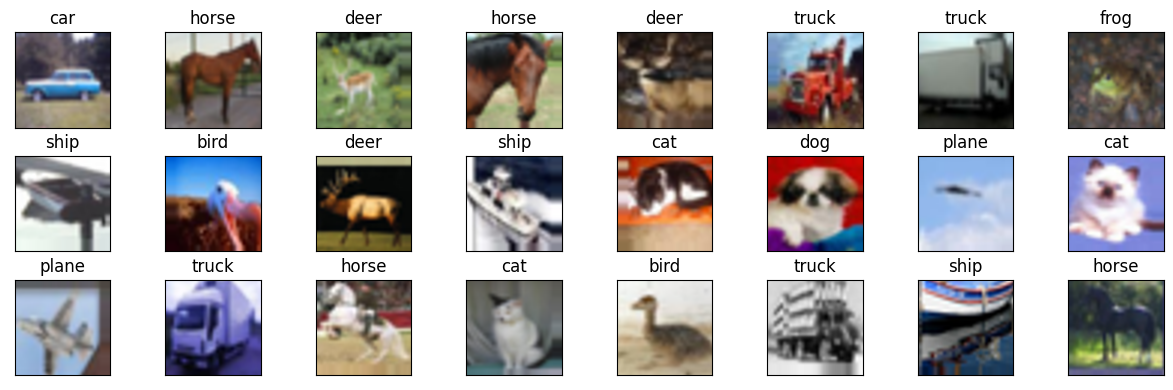

In [25]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [26]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

In [27]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2022-08-12 15:00:20,415: INFO: model_params.mlp1.dropout=0.1
2022-08-12 15:00:20,417: INFO: model_params.mlp1.layer_count=1
2022-08-12 15:00:20,418: INFO: model_params.mlp1.units=128
2022-08-12 15:00:20,462: INFO: learning_rate=0.001
2022-08-12 15:00:20,463: INFO: model_params.mlp1.clip_value=None
2022-08-12 15:00:20,473: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,540,362
Trainable params: 3,540,362
Non-traina

2022-08-12 15:00:20,487: INFO: model_params.mlp1.epochs=15
2022-08-12 15:00:20,488: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1, monitor=val_accuracy)
2022-08-12 15:00:20,488: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:00:20,489: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:00:20,490: INFO: use LearningRateScheduler()
2022-08-12 15:00:20,490: INFO: steps_per_epoch=1562
2022-08-12 15:00:20,491: INFO: start training
2022-08-12 15:00:20,492: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 4.2597 - accuracy: 0.2822INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1/assets


2022-08-12 15:02:06,872: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 106s 67ms/step - loss: 4.2597 - accuracy: 0.2822 - val_loss: 1.9013 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 2/15
1562/1562 [==============================] - ETA: 0s - loss: 1.8310 - accuracy: 0.3742INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1/assets


2022-08-12 15:03:48,952: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 102s 65ms/step - loss: 1.8310 - accuracy: 0.3742 - val_loss: 1.6350 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 3/15
1562/1562 [==============================] - 101s 65ms/step - loss: 1.8102 - accuracy: 0.3787 - val_loss: 1.7005 - val_accuracy: 0.4039 - lr: 0.0010
Epoch 4/15
1466/1562 [===========================>..] - ETA: 6s - loss: 1.8483 - accuracy: 0.3710

2022-08-12 15:07:05,651: INFO: finish training [elapsed time: 405.16 seconds]


KeyboardInterrupt: 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


In [28]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2022-08-12 15:07:09,359: INFO: model_params.lenet1.dropout=0.1
2022-08-12 15:07:09,469: INFO: learning_rate=0.001
2022-08-12 15:07:09,470: INFO: model_params.lenet1.clip_value=None
2022-08-12 15:07:09,476: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 6)         0    

2022-08-12 15:07:09,506: INFO: model_params.lenet1.epochs=15
2022-08-12 15:07:09,507: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000_aug/lenet1, monitor=val_accuracy)
2022-08-12 15:07:09,507: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:07:09,508: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:07:09,509: INFO: use LearningRateScheduler()
2022-08-12 15:07:09,509: INFO: steps_per_epoch=1562
2022-08-12 15:07:09,510: INFO: start training
2022-08-12 15:07:09,511: INFO: use_class_weight=False


Epoch 1/15
1517/1562 [============================>.] - ETA: 3s - loss: 1.7153 - accuracy: 0.3851

2022-08-12 15:08:53,190: INFO: finish training [elapsed time: 103.68 seconds]


KeyboardInterrupt: 

### Custom 1


In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Pretrained Model + Fune-Tune

#### MobileNet V2

In [ ]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape + (3,),
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.Xception(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                            input_shape=input_shape + (3,),
                                            include_top=False)
base_model.summary()

In [ ]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at=100):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(learning_rate=params.learning_rate/5),
                  metrics=['accuracy'])
    return model 

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=rescale)
model.summary()
history = helper.train(model, epochs=20)

In [ ]:
model = fine_tuning(helper, model, base_model)
history = helper.train(model, epochs=30, callbacks=params.fine_tune_callbacks)

## Evaluation

### Best Model

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)